**Original Notebook**: https://colab.research.google.com/github/mostafaelaraby/wavegan-pytorch/blob/master/notebook.ipynb

# **SFX:GAN**


## ❒<font color='purple'> Download repositories and connect to Drive</font>
---




In [11]:
#@markdown #**Check GPU type**
#@markdown ### Factory reset runtime if you don't have the desired GPU.

#@markdown ---




#@markdown V100 = Excellent (*Available only for Colab Pro users*)

#@markdown P100 = Very Good

#@markdown T4 = Good (*preferred*)

#@markdown K80 = Meh

#@markdown P4 = (*Not Recommended*)

#@markdown ---

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e7ba720a-cdab-3ca8-3bab-73e4671a3fbf)


In [12]:
#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically
#@markdown  **(disconnects anyhow after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Pro users will get about 24 hrs usage time[depends])*
#@markdown ---

import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

In [13]:
from google.colab import drive
import os

drive.mount('/content/drive')
#!git clone https://github.com/mostafaelaraby/wavegan-pytorch.git
os.chdir('/content/drive/MyDrive/TFG/SFXGan')
!pip install split-folders
!pip3  install -r requirements.txt
!pip install joblib==1.1.1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 𒀭<font color='pink'>  Model Training </font>


---



### **Parameters**

In [14]:
#%cat params.py
# copy cell content to next cell and edit your params then run
%%writefile params.py
import torch
import random
import numpy as np
import logging
import os

#############################
# DataSet Path
#############################
#@markdown Training dataset
soundlabel = "Meow" #@param ["Acoustic_guitar", "Applause", "Bark", "Bass_drum", "Burping_or_eructation", "Bus", "Cello", "Chime", "Clarinet", "Computer_keyboard", "Cough", "Cowbell", "Double_Bass","Drawer_open_or_close","Electric_piano", "Fart", "Finger_snapping","Fireworks", "Flute", "Glockenspiel", "Gong", "Gunshot_or_gunfire", "Harmonica","Hi-hat","Keys_jangling","Knock","Laughter", "Meow","Microwave_oven","Oboe", "Saxophone","Scissors", "Shatter","Snare_drum", "Squeak","Tambourine", "Tearing", "Telephone","Tearing", "Telephone", "Trumpet", "Violin_or_fiddle","Writing"]
target_signals_dir = "/content/drive/MyDrive/TFG/datasets/" + soundlabel

#############################
# Model Params
#############################
#@markdown Name of the model to be saved
model_prefix = "meow_verified_4_s_400k_16khz" #@param {type:"string"}
output_dir = "/content/drive/MyDrive/TFG/SFXGan/training_process/meow4s_16khz"#@param {type:"string"}
#@markdown ---
n_iterations = 400000 #@param {type:"number"}
lr_g = 1e-5 #@param {type:"number"}
lr_d = 3e-5  #@param {type:"number"}# you can use with discriminator having a larger learning rate than generator instead of using n_critic updates ttur https://arxiv.org/abs/1706.08500
#@markdown ---
beta1 = 0.5
beta2 = 0.9
use_batchnorm=False
validate = True #@param ["True", "False"] {type:"raw"}
decay_lr = False # used to linearly deay learning rate untill reaching 0 at iteration 100,000
generator_batch_size_factor = 1 # in some cases we might try to update the generator with double batch size used in the discriminator https://arxiv.org/abs/1706.08500
n_critic = 1 # update generator every n_critic steps if lr_g = lr_d the n_critic's default value is 5
# gradient penalty regularization factor.
p_coeff = 10
batch_size = 20#@param {type:"number"}
noise_latent_dim = 100  # size of the sampling noise
model_capacity_size = 32    # model capacity during training can be reduced to 32 for larger window length of 2 seconds and 4 seconds
# rate of storing validation and costs params
store_cost_every = 1000#@param {type:"number"}
progress_bar_step_iter_size = 1000# @param {type:"number"}
#############################
# Backup Params
#############################
take_backup = True
backup_every_n_iters = 1000#@param {type:"number"}
save_samples_every = 5000#@param {type:"number"}
if not(os.path.isdir(output_dir)):
    os.makedirs(output_dir)
#############################
# Audio Reading Params
#############################
window_length = 65536 #@param ["16384", "32768", "65536"] {type:"raw"}
sampling_rate = 16000 #@param {type:"number"}
normalize_audio = True
num_channels = 1

#############################
# Logger init
#############################
LOGGER = logging.getLogger('wavegan')
LOGGER.setLevel(logging.DEBUG)
#############################
# Torch Init and seed setting
#############################
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# update the seed
manual_seed = 2019
random.seed(manual_seed)
torch.manual_seed(manual_seed)
np.random.seed(manual_seed)
if cuda:
    torch.cuda.manual_seed(manual_seed)
    torch.cuda.empty_cache()


Overwriting params.py


### **Dataset creation and processing from FSDKaggle2018**

In [15]:
#@title  { form-width: "5%" }
#@title { form-width: "380px" }
from IPython.utils.text import string
import pandas as pd
import shutil
import splitfolders
import librosa
import glob
import os
import params
from IPython.display import Audio
from IPython.core.display import display
from IPython.display import clear_output
import soundfile as sf
import time
import os.path
from scipy import signal
from scipy.io import wavfile
import numpy as np
import importlib

importlib.reload(params) #without this method chaning params will not update, gets stuck
#if os.path.exists("params.cpython-310.pyc"):
 #os.remove("params.cpython-310.pyc") #file is created outside its normal __pycache__ folder, so to prevent multiple files

soundlabel = "Meow" #@param ["Acoustic_guitar", "Applause", "Bark", "Bass_drum", "Burping_or_eructation", "Bus", "Cello", "Chime", "Clarinet", "Computer_keyboard", "Cough", "Cowbell", "Double_Bass","Drawer_open_or_close","Electric_piano", "Fart", "Finger_snapping","Fireworks", "Flute", "Glockenspiel", "Gong", "Gunshot_or_gunfire", "Harmonica","Hi-hat","Keys_jangling","Knock","Laughter", "Meow","Microwave_oven","Oboe", "Saxophone","Scissors", "Shatter","Snare_drum", "Squeak","Tambourine", "Tearing", "Telephone","Tearing", "Telephone", "Trumpet", "Violin_or_fiddle","Writing"]
human_verified= True #@param ["True", "False"] {type:"raw"}
load_dataset = False #@param ["True", "False"] {type:"raw"}
print("The sampling rate for the processed dataset will be:",params.sampling_rate)
print("The window lenght for the processed dataset will be:",params.window_length)
#@markdown ---
#@markdown Shorten Dataset to the training window lenght and normalize
process_dataset = False #@param ["True", "False"] {type:"raw"}
supervise_samples = False #@param ["True", "False"] {type:"raw"}
normalize_dataset = False #@param ["True", "False"] {type:"raw"}
#@markdown *Filter only available if process_dataset = True*
filter = False #@param ["True", "False"] {type:"raw"}
filter_order = 3 #@param {type:"slider", min:1, max:10, step:1}
fc_filter = 600 #@param {type:"integer"}
filter_type = "hp" #@param ["hp", "lp"]
#@markdown ---
split_dataset = False #@param ["True", "False"] {type:"raw"}


#Create a folder with soundlabelname
newpath = '/content/drive/MyDrive/TFG/datasets/' + soundlabel
datasetpath= '/content/drive/MyDrive/TFG/datasets/FSDKaggle2018/'



if load_dataset:
 if os.path.exists(newpath):
  print("Deleting previous dataset folder for",soundlabel,"...")
  shutil.rmtree(newpath)
 print("Creatinng new folder for the dataset...")
 os.makedirs(newpath)
 os.makedirs(newpath+"/all")
 os.makedirs(newpath+"/processed/samples")
#Open Excel files containing labels
 excel_data_train = pd.read_csv('/content/drive/MyDrive/TFG/datasets/FSDKaggle2018/FSDKaggle2018.meta/train_post_competition.csv')
 excel_data_test = pd.read_csv('/content/drive/MyDrive/TFG/datasets/FSDKaggle2018/FSDKaggle2018.meta/test_post_competition_scoring_clips.csv')
# filtering the rows by label and human verified
 if human_verified:
  excel_data_train = excel_data_train[(excel_data_train.label.str.contains(soundlabel)) & (excel_data_train.manually_verified==1)]
  excel_data_test = []
 else:
  excel_data_train = excel_data_train[excel_data_train.label.str.contains(soundlabel)]
  excel_data_test = excel_data_test[excel_data_test.label.str.contains(soundlabel)]

 print("Number of samples matching criteria found on excel_data_train:", len(excel_data_train))
 print("Number of samples matching criteria found on excel_data_test:", len(excel_data_test))

#Create a loop in which everyfilename in the train and test folder is searched in the filtered appropiate excel, and if it is found the file is copied to a new folder
 #train folder
 for root, dirs, files in os.walk(datasetpath+'FSDKaggle2018.audio_train'):
  for name in files:
   for i in range(len(excel_data_train)):
    if name == excel_data_train.iloc[i][0]:
       shutil.copy(datasetpath+"FSDKaggle2018.audio_train/"+name, newpath+"/all")

#test folder
 if human_verified == False:
  for root, dirs, files in os.walk(datasetpath+'FSDKaggle2018.audio_test'):
   for name in files:
    for i in range(len(excel_data_test)):
     if name == excel_data_test.iloc[i][0]:
       shutil.copy(datasetpath+"FSDKaggle2018.audio_test/"+name, newpath+"/all")


#Preprocess all audio, including changing the f_s and the lenght
if process_dataset:
 if os.path.exists("/content/drive/MyDrive/TFG/datasets/{}/processed".format(soundlabel)):
  print("Removing previous processed folder...")
  shutil.rmtree("/content/drive/MyDrive/TFG/datasets/{}/processed".format(soundlabel))
  os.makedirs(newpath+"/processed/samples")

 i=0
 nsamples= len(glob.glob(newpath+"/all/*.wav"))

 for wav_file in glob.glob(newpath+"/all/*.wav"):

  y, sr = librosa.load(wav_file, sr=params.sampling_rate) # Downsample to sampling rate
  y=y[:params.window_length]

  if filter:
      sos = signal.butter(filter_order, fc_filter, 'hp', fs=params.sampling_rate, output='sos') #(order, fc, type, fs, output)
      y = signal.sosfilt(sos, y) #filter signal
  i=i+1
  keep = ''
  if supervise_samples:
   print("              ",i, "/", nsamples)
   def playaudio():
    display(Audio(y, rate=sr, autoplay=True))
   playaudio();
   time.sleep(.1)
   keep = input  ("enter=keep, n+enter=delete:")

  if keep == '':
    sf.write(newpath+"/processed/samples/"+ os.path.basename(wav_file), y, params.sampling_rate)
  else:
    os.remove(wav_file)
    print("Deleted")
    time.sleep(.3)
  clear_output(wait=True)

#Normalize processed dataset - Mean and Standard deviation calculus
if normalize_dataset:
 print("Normalizing dataset...")
 """
 full_dataset= np.array([])
 i=0
 for wav_file in glob.glob(newpath+"/processed/samples/*.wav"):
       i=i+1
       y, samplerate = sf.read(wav_file)
       y_mean= np.mean(y)
       y_std=np.std(y)
       full_dataset= np.concatenate((full_dataset,y))


 ds_mean= np.mean(full_dataset)
 ds_std=np.std(full_dataset)
 checkset= (full_dataset-ds_mean)/ds_std
 print("Number of samples in folder: ",i)
 print("Dataset before norm  -  |Mean:",round(np.mean(full_dataset),2),"| Std: ",round(np.std(full_dataset),2),"|")
 print("Last sample          -  |Mean: ",round(y_mean,2), "|Std: ",round(y_std,2),"|")
"""

 #Save new normalized samples

 for wav_file in glob.glob(newpath+"/processed/samples/*.wav"):
    y, samplerate = sf.read(wav_file)
    """
    y_mean= np.mean(y)
    y_std=np.std(y)
    normalized_y= (y-y_mean)/(y_std*10)
    """
    max_peak = np.max(np.abs(y))
    ratio = 1 / max_peak
    normalized_y = y * ratio
    sf.write(newpath+"/processed/samples/"+ os.path.basename(wav_file), normalized_y, samplerate)

#Later Subdivide the new folder into train test andd split according to percentages and randomness. Create new subfolders
if split_dataset:
 if not os.path.exists("/content/drive/MyDrive/TFG/datasets/{}/train".format(soundlabel)):
  splitfolders.ratio(newpath + "/processed/", output= newpath, seed=1337, ratio=(.8,0.15,0.05))
 else:
  print("Removing old train/test/val folders...")
  shutil.rmtree("/content/drive/MyDrive/TFG/datasets/{}/train".format(soundlabel))
  shutil.rmtree("/content/drive/MyDrive/TFG/datasets/{}/test".format(soundlabel))
  shutil.rmtree("/content/drive/MyDrive/TFG/datasets/{}/val".format(soundlabel))
  splitfolders.ratio(newpath + "/processed", output= newpath, seed=1337, ratio=(.8,0.15,0.05))


The sampling rate for the processed dataset will be: 16000
The window lenght for the processed dataset will be: 65536


### **Train**

In [ ]:
#Model training
!python3  train.py

  9% 35/400 [4:46:33<51:17:46, 505.94s/it, Loss_D WD=60.629005432128906, Loss_G=-1.0660908222198486, Val_G=2.4518115520477295]

## ⿴ <font color='green'>Load Model</font>


---



In [ ]:
model_path = "/content/drive/MyDrive/TFG/SFXGan/models/gan_meow_verified_5_s_200k_16khz.tar" #@param {type:"string"}

import train
import models
import torch
import utils
import params
#target_signals_dir="/content/drive/MyDrive/TFG/drums/"

model = train.WaveGan_GP(params.target_signals_dir + 'train' ,params.target_signals_dir +'valid')
checkpoint= torch.load(model_path)

model.generator.load_state_dict(checkpoint["generator"])
model.discriminator.load_state_dict(checkpoint["discriminator"])
model.optimizer_d.load_state_dict(checkpoint["optimizer_d"])
model.optimizer_g.load_state_dict(checkpoint["optimizer_g"])
model.train_d_cost = checkpoint["train_d_cost"]
model.train_w_distance = checkpoint["train_w_distance"]
model.valid_g_cost = checkpoint["valid_g_cost"]
model.g_cost = checkpoint["g_cost"]

model.generator.eval()


WaveGANGenerator(
  (fc1): Linear(in_features=100, out_features=8192, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv_list): ModuleList(
    (0): Transpose1dLayer(
      (transpose_ops): Sequential(
        (0): ConstantPad1d(padding=(12, 12), value=0)
        (1): Conv1d(512, 256, kernel_size=(25,), stride=(1,))
      )
    )
    (1): Transpose1dLayer(
      (transpose_ops): Sequential(
        (0): ConstantPad1d(padding=(12, 12), value=0)
        (1): Conv1d(256, 128, kernel_size=(25,), stride=(1,))
      )
    )
    (2): Transpose1dLayer(
      (transpose_ops): Sequential(
        (0): ConstantPad1d(padding=(12, 12), value=0)
        (1): Conv1d(128, 64, kernel_size=(25,), stride=(1,))
      )
    )
    (3): Transpose1dLayer(
      (transpose_ops): Sequential(
        (0): ConstantPad1d(padding=(12, 12), value=0)
        (1): Conv1d(64, 32, kernel_size=(25,), stride=(1,))
      )
    )
    (4): Transpose1dLayer(
      (t

## ✴ <font color='skyblue'>Generate samples and plot them </font>
---



/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


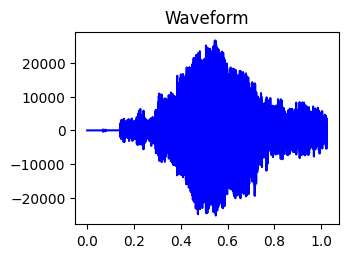

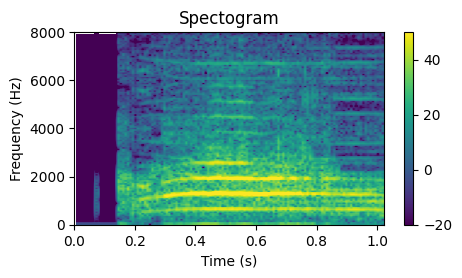

In [ ]:
#@title  { form-width: "5%" }
from scipy.io import wavfile
from IPython.display import Audio
import wave
import numpy as np
import matplotlib.pyplot as plt
import params
import scipy

output_folder = "/content/drive/MyDrive/TFG/generated_samples" #@param {type:"string"}
original_out = "out" #@param {type:"string"}
generated_samples = 10 #@param {type:"number"}
n_samplesplot = 1 #@param {type:"number"}
spec_size_y = 5 #@param {type:"number"}
#device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
fixed_noise = utils.sample_noise(generated_samples).to(params.device)

#latent_space_interpolation(self.generator, n_samples=2)
Sample= model.generator(fixed_noise).detach().cpu().numpy()
utils.save_samples(Sample, output_folder)
#utils.wav_generator(file_path)
#utils.visualize_audio(audio_tensor, False)



#utils.visualize_audio()



#https://learnpython.com/blog/plot-waveform-in-python/
#Plot Spectogram
wav_obj = wave.open(output_folder +'/1.wav', 'rb')
sample_freq = wav_obj.getframerate()
n_samples = wav_obj.getnframes()
t_audio = n_samples/sample_freq
n_channels = wav_obj.getnchannels()
signal_wave = wav_obj.readframes(n_samples)
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
#l_channel = signal_array[0::2]
#r_channel = signal_array[1::2]
plt.figure(figsize=(spec_size_y-1.6, spec_size_y/2))
plt.title('Waveform')
plt.plot(np.linspace(0,t_audio, params.window_length),signal_array,'b')
plt.figure(figsize=(spec_size_y, spec_size_y/2))
plt.specgram(signal_array, Fs=sample_freq, vmin=-20, vmax=50)
plt.title('Spectogram')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(0, t_audio)
plt.colorbar()
plt.show()

#Check file reading from dataset
sum=np.array([])
for i in range(generated_samples):
 samplerate, data = wavfile.read(output_folder +'/{}.wav'.format(i+1))
 sum=np.concatenate((sum,data))

Audio(sum, rate=samplerate, autoplay=True)


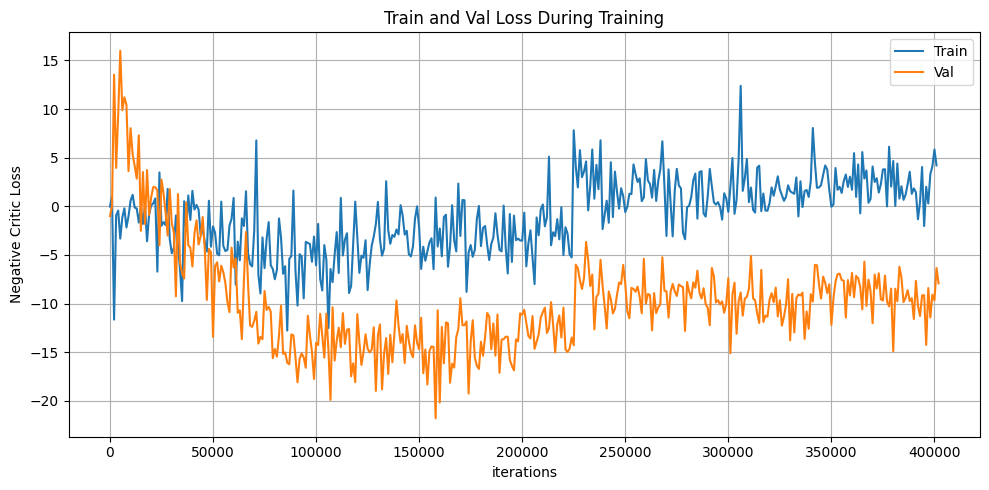

[-1, -0.010766570456326008, 13.535284996032715, 3.9442527294158936, 9.458113670349121, 15.993842124938965, 9.870966911315918, 11.207723617553711, 10.451904296875, 3.6136441230773926, 8.028940200805664, 5.353296756744385, 4.136899471282959, 2.840001106262207, 7.292716979980469, -2.5275256633758545, 3.519880771636963, -1.828097939491272, 3.7203567028045654, -0.896235466003418, 0.9275197982788086, 1.9777336120605469, 1.9574285745620728, 1.6257301568984985, -4.012462139129639, 2.7401180267333984, 1.3067353963851929, -0.6659330725669861, -3.005552053451538, 1.7710113525390625, -1.7780379056930542, -2.669680118560791, -9.262846946716309, 1.2581264972686768, -5.827382564544678, -6.877458095550537, -7.421591281890869, 0.4050561487674713, -3.9977853298187256, -4.255932807922363, -6.196873188018799, -2.7925121784210205, -1.4490386247634888, -3.9335155487060547, -3.077666997909546, -1.1122397184371948, -4.434224605560303, -9.633429527282715, -4.384599685668945, -4.7329230308532715, -13.4233675003

In [ ]:
#@title Show costs

loss_1=model.g_cost
loss_2=model.valid_g_cost
x1 = [i*params.store_cost_every for i in range(len(loss_1))]
x2 = [i*params.store_cost_every for i in range(len(loss_2))]
plt.figure(figsize=(10, 5))
plt.title("{} and {} Loss During Training".format("Train", "Val"))
plt.plot(x1,loss_1, label="Train")
plt.plot(x2,loss_2, label= "Val")
plt.xlabel("iterations")
plt.ylabel("Negative Critic Loss")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

print(model.valid_g_cost)


##  <font color='red'>Guitar Examples</font>


---



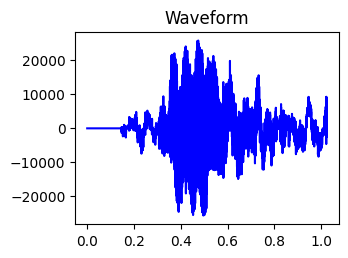

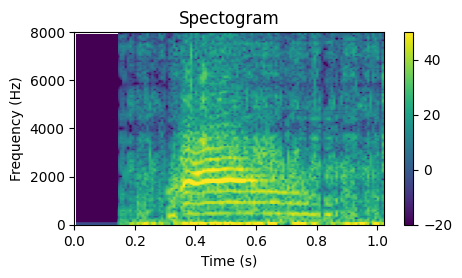

In [ ]:
#@title  { form-width: "5%" }
from scipy.io import wavfile
from IPython.display import Audio
import wave
import numpy as np
import matplotlib.pyplot as plt
import params
import scipy

output_folder = "/content/drive/MyDrive/TFG/generated_samples" #@param {type:"string"}
original_out = "out" #@param {type:"string"}
generated_samples = 10 #@param {type:"number"}
n_samplesplot = 1 #@param {type:"number"}
spec_size_y = 5 #@param {type:"number"}
#device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
fixed_noise = utils.sample_noise(generated_samples).to(params.device)

#latent_space_interpolation(self.generator, n_samples=2)
Sample= model.generator(fixed_noise).detach().cpu().numpy()
utils.save_samples(Sample, output_folder)
#utils.wav_generator(file_path)
#utils.visualize_audio(audio_tensor, False)



#utils.visualize_audio()



#https://learnpython.com/blog/plot-waveform-in-python/
#Plot Spectogram
wav_obj = wave.open(output_folder +'/1.wav', 'rb')
sample_freq = wav_obj.getframerate()
n_samples = wav_obj.getnframes()
t_audio = n_samples/sample_freq
n_channels = wav_obj.getnchannels()
signal_wave = wav_obj.readframes(n_samples)
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
#l_channel = signal_array[0::2]
#r_channel = signal_array[1::2]
plt.figure(figsize=(spec_size_y-1.6, spec_size_y/2))
plt.title('Waveform')
plt.plot(np.linspace(0,t_audio, params.window_length),signal_array,'b')
plt.figure(figsize=(spec_size_y, spec_size_y/2))
plt.specgram(signal_array, Fs=sample_freq, vmin=-20, vmax=50)
plt.title('Spectogram')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(0, t_audio)
plt.colorbar()
plt.show()

#Check file reading from dataset
sum=np.array([])
for i in range(generated_samples):
 samplerate, data = wavfile.read(output_folder +'/{}.wav'.format(i+1))
 sum=np.concatenate((sum,data))

Audio(sum, rate=samplerate, autoplay=True)


## <font color='red'>Cat Examples</font>


---



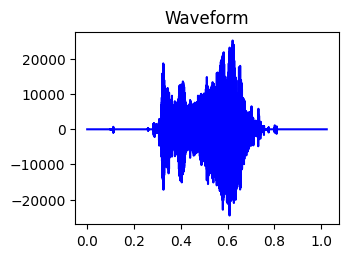

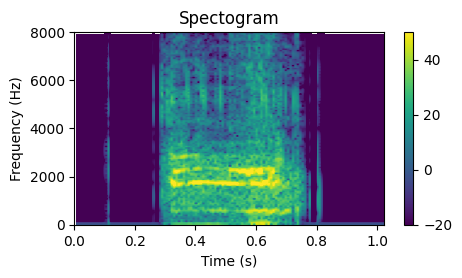

In [ ]:
#@title  { form-width: "5%" }
from scipy.io import wavfile
from IPython.display import Audio
import wave
import numpy as np
import matplotlib.pyplot as plt
import params
import scipy

output_folder = "/content/drive/MyDrive/TFG/generated_samples" #@param {type:"string"}
original_out = "out" #@param {type:"string"}
generated_samples = 10 #@param {type:"number"}
n_samplesplot = 1 #@param {type:"number"}
spec_size_y = 5 #@param {type:"number"}
#device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
fixed_noise = utils.sample_noise(generated_samples).to(params.device)

#latent_space_interpolation(self.generator, n_samples=2)
Sample= model.generator(fixed_noise).detach().cpu().numpy()
utils.save_samples(Sample, output_folder)
#utils.wav_generator(file_path)
#utils.visualize_audio(audio_tensor, False)



#utils.visualize_audio()



#https://learnpython.com/blog/plot-waveform-in-python/
#Plot Spectogram
wav_obj = wave.open(output_folder +'/1.wav', 'rb')
sample_freq = wav_obj.getframerate()
n_samples = wav_obj.getnframes()
t_audio = n_samples/sample_freq
n_channels = wav_obj.getnchannels()
signal_wave = wav_obj.readframes(n_samples)
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
#l_channel = signal_array[0::2]
#r_channel = signal_array[1::2]
plt.figure(figsize=(spec_size_y-1.6, spec_size_y/2))
plt.title('Waveform')
plt.plot(np.linspace(0,t_audio, params.window_length),signal_array,'b')
plt.figure(figsize=(spec_size_y, spec_size_y/2))
plt.specgram(signal_array, Fs=sample_freq, vmin=-20, vmax=50)
plt.title('Spectogram')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(0, t_audio)
plt.colorbar()
plt.show()

#Check file reading from dataset
sum=np.array([])
for i in range(generated_samples):
 samplerate, data = wavfile.read(output_folder +'/{}.wav'.format(i+1))
 sum=np.concatenate((sum,data))

Audio(sum, rate=samplerate, autoplay=True)
